## Few Shot Compositional Font Generation with Dual Memory

- FFG(Font Generation) 관련 논문인 DMFont를 읽다가 모델 구조를 코딩한 방법이 인상적이여서 기록.


#### 1. encoder의 head들
- 한글의 특성상 하나의 글자(glyph)는 초성, 중성, 종성 세 가지 컴포넌트(sub-glyph)로 이루어지는데, 이 세 가지 컴포넌트에 각각의 encoder head를 지정한다.
- 아래는 encoder의 구조 그림과 encoder 코드다.
- 깔끔하게 짠 코드 방식이 본받을만 하다.

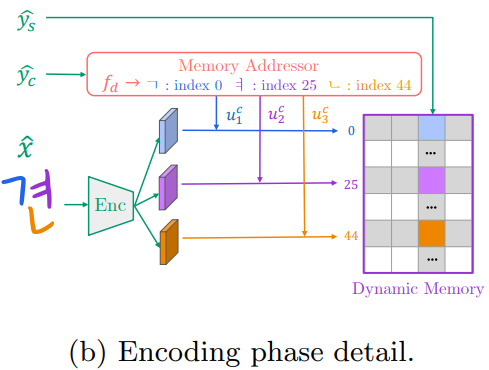

In [ ]:
from functools import partial
import torch
import torch.nn as nn
from base.modules import ConvBlock, ResBlock, GCBlock, SAFFNBlock


class ComponentEncoder(nn.Module):
    def __init__(self, n_heads=3):
        super().__init__()
        self.n_heads = n_heads

        ConvBlk = partial(ConvBlock, norm='none', activ='relu', pad_type='zero') # functools의 partial 함수로 Block 함수들을 인자가 변화할 때마다 여러번 불러올 필요없이 
        ResBlk = partial(ResBlock, norm='none', activ='relu', pad_type='zero')
        SAFFNBlk = partial(SAFFNBlock, C_qk_ratio=0.5, n_heads=2, area=False, ffn_mult=2)

        C = 32
        self.body = nn.ModuleList([
            ConvBlk(1, C, 3, 1, 1, norm='none', activ='none'),  # 128x128
            ConvBlk(C*1, C*2, 3, 1, 1, downsample=True),  # 64x64
            GCBlock(C*2),
            ConvBlk(C*2, C*4, 3, 1, 1, downsample=True),  # 32x32
            SAFFNBlk(C*4, size=32, rel_pos=True),
        ])

        self.heads = nn.ModuleList([
            nn.ModuleList([
                ResBlk(C*4, C*4, 3, 1),
                SAFFNBlk(C*4, size=32, rel_pos=False),
                ResBlk(C*4, C*4, 3, 1),
                ResBlk(C*4, C*8, 3, 1, downsample=True),  # 16x16
                SAFFNBlk(C*8, size=16, rel_pos=False),
                ResBlk(C*8, C*8)
            ]) for _ in range(n_heads) # 초성, 중성, 종성으로 3개의 sub glyphs를 위한 각각의 헤드 놓음
        ])

        self.skip_layer_idx = 2
        self.feat_shape = {"last": (C*8, 16, 16), "skip": (C*4, 32, 32)}

    def forward(self, x):
        ret_feats = {}

        for layer in self.body:
            x = layer(x)

        xs = [x] * self.n_heads
        n_layers = len(self.heads[0]) 
        for lidx in range(n_layers): # forward에서 3개의 sub-glyphs를 위한 head 불러오기
            for hidx, head in enumerate(self.heads):
                layer = head[lidx]
                xs[hidx] = layer(xs[hidx])
            if lidx == self.skip_layer_idx:
                ret_feats["skip"] = torch.stack(xs, dim=1)

        ret_feats["last"] = torch.stack(xs, dim=1)

        return ret_feats

    def get_feat_shape(self):
        return self.feat_shape


#### 2. Dynamic Memory
- (row, column) = (sub_glyph, font style) 정보를 담은 memory 생성. 각 주소에는 encoder를 거친 feature를 담는다.
- attention의 key, value, query처럼, featuremap을 저장하고 불러오는 자료구조로써 처리한 것이 인상적이다.


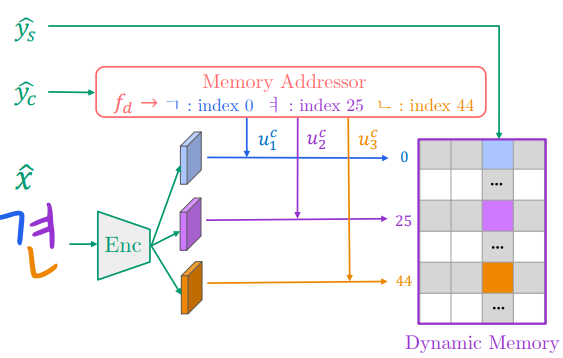

In [ ]:
class DynamicMemory:
    def __init__(self):
        self.memory = {}
        self.reset()

    def write(self, style_ids, comp_ids, sc_feats):
        assert len(style_ids) == len(comp_ids) == len(sc_feats), "Input sizes are different"

        for style_id, comp_ids_char, sc_feats_char in zip(style_ids, comp_ids, sc_feats):
            for comp_id, sc_feat in zip(comp_ids_char, sc_feats_char):
                self.write_point(style_id, comp_id, sc_feat)

    def write_point(self, style_id, comp_id, sc_feat):
        sc_feat = sc_feat.squeeze() # 차원 길이(?)가 1인 모든 차원을 제거
        self.memory.setdefault(int(style_id), {}) \
                   .setdefault(int(comp_id), []) \
                   .append(sc_feat) 
        ## memory = {style_id : {{comp_id} : [sc_feature], ...}, ...}

    def read_point(self, style_id, comp_id, reduction='mean'):
        sc_feats = self.memory[int(style_id)][int(comp_id)]
        return reduce_features(sc_feats, reduction)

    def read_char(self, style_id, comp_ids, reduction='mean'):
        char_feats = []
        for comp_id in comp_ids:
            comp_feat = self.read_point(style_id, comp_id, reduction)
            char_feats.append(comp_feat)

        char_feats = torch.stack(char_feats)  # [n_comps, mem_shape]
        return char_feats

    def read(self, style_ids, comp_ids, reduction='mean'):
        feats = []
        for style_id, comp_ids_char in zip(style_ids, comp_ids):
            char_feat = self.read_char(style_id, comp_ids_char, reduction)
            feats.append(char_feat)

        feats = torch.stack(feats)
        return feats

    def reset(self):
        self.memory = {}


#### 3. Persistent Memory
- 학습가능한 (n_components, shape) embedding

In [ ]:
class PersistentMemory(nn.Module):
    def __init__(self, n_comps, shape):
        """
        Args:
            mem_shape: (C, H, W) tuple (3-elem)
        """
        super().__init__()
        self.shape = shape

        self.bias = nn.Parameter(torch.randn(n_comps, *shape))
        C = shape[0]
        self.hypernet = nn.Sequential(
            ConvBlock(C, C),
            ConvBlock(C, C),
            ConvBlock(C, C)
        )

    def read(self, comp_ids):
        b = self.bias[comp_ids]  # [B, 3, mem_shape]

        return b

    def forward(self, x, comp_ids):
        """
        Args:
            x: [B, 3, *mem_shape]
            comp_addr: [B, 3]
        """
        b = self.read(comp_ids)  # [B, 3, *mem_shape] * 2

        B = b.size(0)
        b = b.flatten(0, 1)
        b = self.hypernet(b)
        b = split_dim(b, 0, B)

        return x + b


class Memory(nn.Module):
    # n_components: # of total comopnents. 19 + 21 + 28 = 68 in kr.
    STYLE_ID = -1

    def __init__(self, n_comps, shape, persistent=False):
        super().__init__()
        self.dynamic_memory = DynamicMemory()
        self.persistent = persistent
        if self.persistent:
            self.persistent_memory = PersistentMemory(n_comps, shape)
        self.shape = shape

    def write(self, style_ids, comp_ids, sc_feats):
        self.dynamic_memory.write(style_ids, comp_ids, sc_feats)

    def read(self, style_ids, comp_ids, reduction="mean"):
        feats = self.dynamic_memory.read(style_ids, comp_ids, reduction).cuda()
        if self.persistent:
            feats = self.persistent_memory(feats, comp_ids)

        return feats

    def reset_dynamic(self):
        """ Reset dynamic memory """
        self.dynamic_memory.reset()
